# Week 4: HTTP requests and spatial data
The **objective** of this lecture is to learn more about data acquisition and access via web service APIs, and even a brief exploration of the developer console.  We will find and access _spatial_ data and begin to work with the `geopandas` project.

In [23]:
import requests
import pandas

## One of the most useful free APIs

I use this often. OpenStreetMap (OSM) is a crowd-sourced map of the world. Nominatum is a web service that allows users to interact with OSM data. The input for the Nominatum geocoder is an address or a place name; the output is a latitude and longitude (and other OSM metadata). The reverse geocoder accepts a latitude and longitude, and returns the place name and address - and sometimes even the boundary of the facility, if requested.

In [5]:
url = "https://nominatim.openstreetmap.org/reverse"
payload = {
    "format": "json",
    "lat": 37.8692322,
    "lon": -122.25755
}
r = requests.get(url, params=payload)
response = r.json()

In [9]:
print(response.keys())

print(response["display_name"])

dict_keys(['place_id', 'licence', 'osm_type', 'osm_id', 'lat', 'lon', 'display_name', 'address', 'boundingbox'])
Hearst Memorial Gymnasium, Bancroft Way, Southside, Berkeley, Alameda County, California, 94720, United States


In [13]:
url = "https://nominatim.openstreetmap.org/reverse"
payload = {
    "format": "json",
    "lat": 37.87, # round to 2 significant digits
    "lon": -122.26 # rount to 2 significant digits
}
r = requests.get(url, params=payload)
response = r.json()
print(response["display_name"])

César E. Chavez Student Center, Sproul Plaza, Southside, Berkeley, Alameda County, California, 94704, United States


## Creating a function

The only thing we did was change the values of certain variables.  For this, instead of copying code, we can create a template instead.

In [15]:
def get_name(lat, lon):
    """
    Accepts a latitude and longitude.
    Returns the OSM place name.
    """
    url = "https://nominatim.openstreetmap.org/reverse"
    payload = {
        "format": "json",
        "lat": lat,
        "lon": lon
    }

    r = requests.get(url, params=payload)
    response = r.json()
    return response["display_name"]

get_name(37.87, -122.26)

'César E. Chavez Student Center, Sproul Plaza, Southside, Berkeley, Alameda County, California, 94704, United States'

## Finding (spatial) data
The requests package allows access to data. How do we find the data we want to access. Often, websites will rely on data. Let's try to find data by looking inside the developer console. [This was a helpful article](https://support.monday.com/hc/en-us/articles/360002197259-How-to-Open-the-Developer-Console) on how to open the developer console in different browsers.

In [18]:
url = "https://global-coal-map-2020.s3.eu-west-2.amazonaws.com/data/coal2020.geojson"
r = requests.get(url)
response = r.json()
features = response["features"]

In [19]:
len(features)

5370

In [21]:
features[0]

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [111.3589, 40.19523]},
 'properties': {'annualCarbon': 30.69,
  'capacity': 6720,
  'coalType': 'Bituminous',
  'country': 'China',
  'plant': 'Datang Tuoketuo power station',
  'status': 'Operating',
  'Tracker ID': 'G102182',
  'type': 'Subcritical',
  'retire1': 2100,
  'retire2': 2100,
  'retire3': 2100,
  'start1': 2003,
  'start2': 2017,
  'year1': 2017,
  'year2': 2020,
  'startLabel': '2003 - 2017',
  'regionLabel': 'China'}}

In [24]:
rows = [f["properties"] for f in features]
df = pandas.DataFrame(rows)
df.head()

,annualCarbon,capacity,coalType,country,plant,status,Tracker ID,type,retire1,retire2,retire3,start1,start2,year1,year2,startLabel,regionLabel
0,30.69,6720.0,Bituminous,China,Datang Tuoketuo power station,Operating,G102182,Subcritical,2100,2100,2100.0,2003,2017,2017,2020,2003 - 2017,China
1,26.96,6600.0,Unknown,Egypt,Hamarawein IPP coal project,Pre-permit,,Ultra-super,2100,2100,NaN,2100,2100,2020,2020,?,Africa and Middle East
2,28.40,6400.0,Unknown / Bituminous,South Korea,Taean power station,Operating,G109800,IGCC,2100,2100,2100.0,1995,2017,2017,2020,1995 - 2017,Other Asia
3,26.69,6040.0,Bituminous,South Korea,Dangjin power station,Operating,G101952,Supercritical,2100,2100,2100.0,1999,2016,2016,2020,1999 - 2016,Other Asia
4,24.51,6000.0,Unknown,Bangladesh,Phulbari Coal Project (China Gezhouba),Announced,,Ultra-super,2100,2100,NaN,2100,2100,2020,2020,?,Other Asia


<BarContainer object of 10 artists>

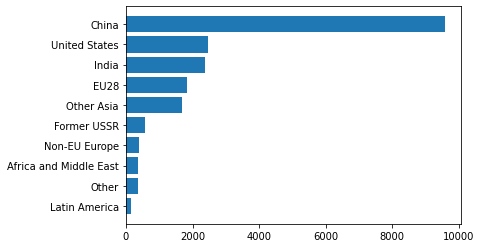

In [43]:
operating = df[df.status == "Operating"]
operating.groupby("coalType")["annualCarbon"].sum()
hist_data = operating.groupby("regionLabel")["annualCarbon"].sum()
hist_data = hist_data.reset_index().sort_values("annualCarbon")
plt.barh(hist_data.regionLabel, hist_data.annualCarbon)

## Plotting spatial data 
While we had access to the geographic coordinates, we didn't really use them.  With `geopandas` it is pretty quick to start to create a map.

In [20]:
# !pip install geopandas
import geopandas

In [29]:
# automatically added a geometry field
power_plants = geopandas.read_file("https://global-coal-map-2020.s3.eu-west-2.amazonaws.com/data/coal2020.geojson")

/Users/danhammer/streamlitenv/lib/python3.7/site-packages/geopandas/datasets/naturalearth_lowres/naturalearth_lowres.shp


<AxesSubplot:>

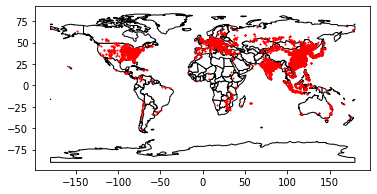

In [34]:
print(geopandas.datasets.get_path('naturalearth_lowres'))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
power_plants.plot(ax=base, color='red', markersize=1)

<AxesSubplot:>

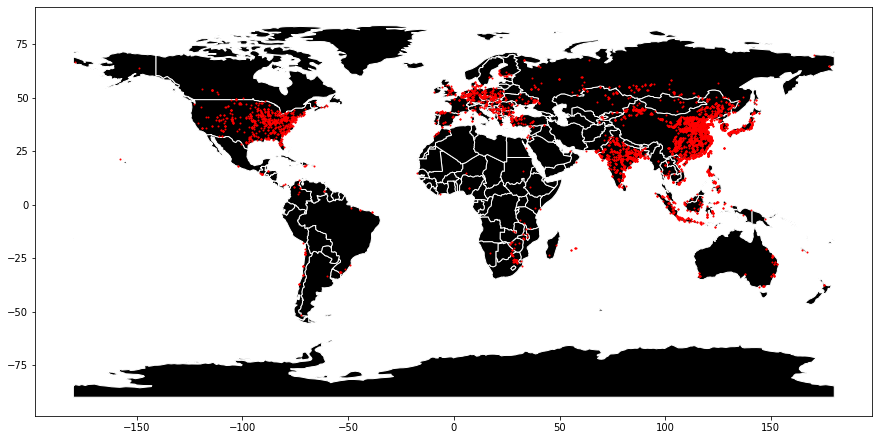

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))

world.plot(
    ax=ax,
    color="black",
    edgecolor="white"
)

power_plants.plot(
    ax=ax, 
    color='red', 
    markersize=1
)